# Clustering of Toronto neighborhoods

In [1]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup

#### Load wikipedia page with postal codes of Toronto

In [2]:
wikipedia_link="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

r = requests.get(wikipedia_link)
page = r.text

#### Locate embedded table with postal codes, boroughs and and extract it

In [3]:
pos1=page.find('<table class="wikitable sortable">')
pos2=page.find("</table>", pos1)
table_text = page[pos1:pos2+8]

In [4]:
table_text=table_text.replace("\n","")
soup = BeautifulSoup(table_text,"lxml")

##### Extract column names from table

In [5]:
rowl = []
tablerows = soup.find_all("tr")  

rowh = soup.find_all("th") 
colnames=[]
for rh in rowh:
    colnames.append(rh.string)
colnames  

['Postcode', 'Borough', 'Neighbourhood']

##### Extract all rows and put in a python dataframe 

In [6]:
rowr=soup.find_all("tr")
allrows=[]
for rr in rowr:
    rd = rr.find_all("td")
    currow=[]
    for rrd in rd:
        currow.append(rrd.string) 
    allrows.append(currow)
    
alldf=pd.DataFrame(allrows, columns=colnames).iloc[1:,]
alldf.head()

,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


In [7]:
print("Total number of scraped rows except header is: ", alldf.shape[0])

Total number of scraped rows except header is:  289


#####  Skip rows  with both "Not Assigned" Boroughs and Neighborhods and assign Neighborhood = Borough if Borough is known

In [8]:
alldf = alldf[alldf["Borough"] != "Not assigned"]
df1=alldf.loc[alldf.Neighbourhood == 'Not assigned']
for index, row in df1.iterrows():
    alldf.Neighbourhood[index] = row.Borough

##### Combine rows with the same Borough into the same  row with Neighborhoods separated by comma

In [9]:
##create Pivit table with columns equal to All found Neighbourhoods
alldf["Val"] = 1
tab=pd.pivot_table(alldf, values="Val", columns="Neighbourhood", aggfunc=np.sum, index=["Postcode","Borough"])
tab=tab.fillna("")
tab.columns    

Index([Adelaide, Agincourt, Agincourt North, Albion Gardens, Alderwood,
       Bathurst Manor, Bathurst Quay, Bayview Village, Beaumond Heights,
       Bedford Park,
       ...
       Willowdale South, Willowdale West, Wilson Heights, Woburn,
       Woodbine Gardens, Woodbine Heights, York Mills, York Mills West,
       York University, Yorkville],
      dtype='object', name='Neighbourhood', length=210)

In [10]:
### function to combine neigbourhoods into one line, separated by comma
def compress_neighbourhoods(itm):
    str = ""
    for key, value in itm:
        if value == 1.0: 
            if str == "": str = (str + key)
            else: str = str + "," + key
    return str

In [11]:
### Produce target table with one row per Postcode and comma separated Neighbourhoods
nr=tab.shape[0]
dict = {}
for cur in range(nr):
    dict[cur] = {"Postcode": tab.index[cur][0], "Borough": tab.index[cur][1], "Neighbourhoods": compress_neighbourhoods(tab.iloc[cur,].items())}

toronto_neighbourhoods=pd.DataFrame(dict).transpose().loc[:,["Postcode","Borough","Neighbourhoods"]]
toronto_neighbourhoods.head(5)

,Postcode,Borough,Neighbourhoods
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
toronto_neighbourhoods.tail(5)

,Postcode,Borough,Neighbourhoods
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie..."
101,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
102,M9W,Etobicoke,Northwest


In [13]:
print("Number of rows in the dataframe:", toronto_neighbourhoods.shape[0])

Number of rows in the dataframe: 103


### Add Geolocation coordinates to Postal Codes

In [14]:
!conda install -c conda-forge geocoder --yes
import geocoder

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geocoder:   1.38.1-py_0  conda-forge
    orderedset: 2.0-py35_0   conda-forge
    ratelim:    0.1.6-py35_0 conda-forge

orderedset-2.0 100% |################################| Time: 0:00:00   1.84 MB/s
ratelim-0.1.6- 100% |################################| Time: 0:00:00  11.24 MB/s
geocoder-1.38. 100% |################################| Time: 0:00:00  42.72 MB/s


In [16]:
#Load provided file with geo coordinates, as the provided method of finding coordinates through geocoder seems to be problematic
!wget -q -O "ontario_postalcode_coord.xls" http://cocl.us/Geospatial_data
geodata = pd.read_csv("ontario_postalcode_coord.xls")
geodata.columns=["Postcode", "Latitude", "Longtitude"]
geodata.head()    

,Postcode,Latitude,Longtitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [17]:
print("Number of rows in geodata dataframe:", geodata.shape[0])

Number of rows in geodata dataframe: 103


#### Resulting table of neighbourhoods with geolocations

In [18]:
toronto_neighbourhoods=pd.merge(toronto_neighbourhoods, geodata, how='left', on="Postcode", left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

toronto_neighbourhoods.head()

,Postcode,Borough,Neighbourhoods,Latitude,Longtitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [19]:
pd.set_option('display.max_colwidth', -1)
toronto_neighbourhoods.loc[toronto_neighbourhoods['Postcode'].isin(['M5G','M2H','M4B','M1J','M4G','M4M','M1R','M9V','M9L','M5V','M1B','M5A'])]

,Postcode,Borough,Neighbourhoods,Latitude,Longtitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
11,M1R,Scarborough,"Maryvale,Wexford",43.750072,-79.295849
17,M2H,North York,Hillcrest Village,43.803762,-79.363452
35,M4B,East York,"Parkview Hill,Woodbine Gardens",43.706397,-79.309937
38,M4G,East York,Leaside,43.709060,-79.363452
43,M4M,East Toronto,Studio District,43.659526,-79.340923
53,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
68,M5V,Downtown Toronto,"Bathurst Quay,CN Tower,Harbourfront West,Island airport,King and Spadina,Railway Lands,South Niagara",43.628947,-79.394420


### Clustering of neigbourhoods

##### Draw borough centers on the Map

In [20]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00 594.43 kB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  33.61 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  37.92 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  31.42 MB/s


In [21]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.17.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00 220.22 kB/s
geopy-1.17.0-p 100% |################################| Time: 0:00:00 335.34 kB/s


In [22]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


###### Map of boroughs of Toronto, ON

In [23]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(toronto_neighbourhoods['Latitude'], toronto_neighbourhoods['Longtitude'], toronto_neighbourhoods['Borough'], toronto_neighbourhoods['Neighbourhoods']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Cluster boroughs according to the venues located nearby

 #### we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [25]:
# @hidden_cell
CLIENT_ID = '0WCCOQYDV0DPIHCURTTUSRY31JLTSKEF2E3NU4INJFA0QGJB' # your Foursquare ID
CLIENT_SECRET = 'YN4FQDUUBPQBXJX4V0ISOTGVHT4MQ1MPI22E0F2GU2UR2R3N' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [26]:
def getNearbyVenues(postcodes, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for postcode, lat, lng in zip(postcodes, latitudes, longitudes):
        #print(postcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
#fill in venues in radius 2km for each postcode, limited by LIMIT number per borough
toronto_venues = getNearbyVenues(toronto_neighbourhoods["Postcode"], toronto_neighbourhoods["Latitude"], toronto_neighbourhoods["Longtitude"], radius=2000)

In [29]:
print("Number of venues identified: %d:" %(toronto_venues.shape[0]))
toronto_venues.head()

Number of venues identified: 8500:


,Postcode,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Toronto Pan Am Sports Centre,43.790623,-79.193869,Athletics & Sports
2,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
3,M1B,43.806686,-79.194353,Toronto Zoo,43.820582,-79.181551,Zoo
4,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa


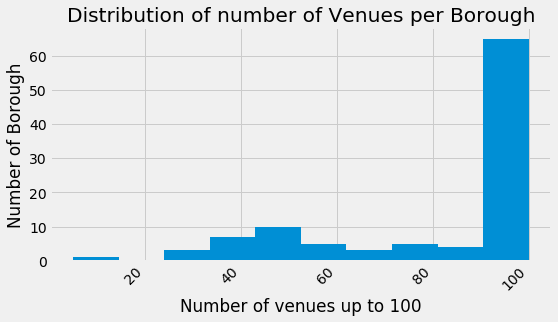

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(toronto_venues.groupby("Postcode").count()["Venue"], bins=10)
labels = ax.get_xticklabels()
plt.style.use('fivethirtyeight')
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(title = "Distribution of number of Venues per Borough", xlabel = "Number of venues up to 100", ylabel = "Number of Borough")
plt.show()

#### Let's find out how many unique categories can be curated from all the returned venues

In [36]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 329 uniques categories.


#### Create frequency matrix per venue type per borough

In [40]:
#create Pivot table to reflect each possible venue type as a column
toronto_venues["Val"] = 1
tab=pd.pivot_table(toronto_venues, values="Val", columns="Venue Category", aggfunc=np.sum, index=["Postcode"])
tab=tab.fillna(0)
tab["venues_qty"] = tab.sum(axis=1)
for i in range(tab.shape[1]-1):
    tab.iloc[:, i]=tab.iloc[:, i]/tab.iloc[:, tab.shape[1]-1]
tab.drop("venues_qty",axis=1,inplace=True) 
tab.head()

Venue Category,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Postcode,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.021277,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.042553,0.382979
M1C,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000
M1E,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000
M1G,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000
M1H,0.0,0.0,0.0,0.000000,0.0,0.0,0.03,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.01,0.000000,0.000000


#### Select Top 10 popular venue types per borough

In [38]:
#create dataframe with 10 most popular venue types per borough
dict={}
for i in range(tab.shape[0]):
    t=tab.iloc[i,:]
    t=t[t>0].sort_values(ascending=False)
    dict[i]={"Postcode": t.name}
    for j in range(0, min(10, t.size)):
        dict[i].update({"Venue " + str(j+1): t.index[j]})
dict
toronto_mostpopular_venues=pd.DataFrame(dict).transpose().iloc[:, [0,1,3,4,5,6,7,8,9,10,2]]

In [39]:
toronto_mostpopular_venues.head(20)

,Postcode,Venue 1,Venue 2,Venue 3,Venue 4,Venue 5,Venue 6,Venue 7,Venue 8,Venue 9,Venue 10
0,M1B,Zoo Exhibit,Fast Food Restaurant,Athletics & Sports,Pizza Place,Zoo,Fruit & Vegetable Store,Bakery,Bus Station,Café,Caribbean Restaurant
1,M1C,Coffee Shop,Pizza Place,Pharmacy,Breakfast Spot,Sandwich Place,Supermarket,Food & Drink Shop,Bank,Bar,Beer Store
2,M1E,Pizza Place,Coffee Shop,Pharmacy,Park,Gym,Fast Food Restaurant,Train Station,Food & Drink Shop,Athletics & Sports,Bank
3,M1G,Coffee Shop,Fast Food Restaurant,Sandwich Place,Discount Store,Grocery Store,Furniture / Home Store,Park,Pharmacy,Indian Restaurant,Chinese Restaurant
4,M1H,Coffee Shop,Clothing Store,Gym,Indian Restaurant,Sandwich Place,Bank,Fast Food Restaurant,Wings Joint,Pharmacy,Pizza Place
5,M1J,Fast Food Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Grocery Store,Pharmacy,Liquor Store,Big Box Store,Discount Store,Beer Store
6,M1K,Grocery Store,Coffee Shop,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Beer Store,Discount Store,Sporting Goods Shop,Bank
7,M1L,Coffee Shop,Fast Food Restaurant,Sandwich Place,Burger Joint,Pizza Place,Shoe Store,Beer Store,Ice Cream Shop,Bank,Burrito Place
8,M1M,Harbor / Marina,Park,Coffee Shop,Beach,Sandwich Place,Pharmacy,Fast Food Restaurant,Grocery Store,Fish & Chips Shop,Bank
9,M1N,Coffee Shop,Bank,Grocery Store,Park,Beer Store,Pizza Place,Golf Course,Convenience Store,Construction & Landscaping,College Stadium


#### Cluster Toronto boroughs with K-Means clustering, using frequency matrix as input

In [42]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [43]:
# set number of clusters
kclusters = 4 

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(tab)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [49]:
tab["cluster"] = kmeans.labels_
print("Number of boroughs per cluster")
pd.DataFrame({"Cluster": np.unique(kmeans.labels_, return_counts = True)[0], "Numbers": np.unique(kmeans.labels_, return_counts = True)[1]})

Number of boroughs per cluster


,Cluster,Numbers
0,0,47
1,1,24
2,2,31
3,3,1


In [50]:
tt = pd.DataFrame([tab.index, tab.iloc[:,-1]]).transpose()
tt.columns=["Postcode",'cluster']
toronto_neighbourhoods_clustered=pd.merge(toronto_neighbourhoods, tt, how='right', on="Postcode", suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
toronto_neighbourhoods_clustered.head(10)

,Postcode,Borough,Neighbourhoods,Latitude,Longtitude,cluster
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353,2
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill",43.784535,-79.160497,0
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,0
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,0
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0


#### Clustered boroughs on the Map with different colour per cluster

In [52]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_neighbourhoods_clustered['Latitude'], toronto_neighbourhoods_clustered['Longtitude'], 
                                  toronto_neighbourhoods_clustered['Neighbourhoods'], toronto_neighbourhoods_clustered['cluster']):
    label = folium.Popup(' Cluster ' + str(cluster) + ': ' + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyse difference among clusters on the basis of 10 most used venue types per borough within the cluster

In [54]:
ddd = {}
for cc in range(kclusters): 
    dd = {}
    cluster = toronto_mostpopular_venues.loc[toronto_mostpopular_venues['Postcode'].isin(toronto_neighbourhoods_clustered.loc[toronto_neighbourhoods_clustered["cluster"] == cc, "Postcode"])]
    for i in range(9):
        sel = cluster.groupby(cluster.columns[i+1]).count()["Postcode"].sort_values(ascending=False)
        if (sel.shape[0] != 0): 
            dd[cluster.columns[i+1]] = sel.index[0]
        else: dd[cluster.columns[i+1]] = ""     
    ddd[cc] = dd
    
    most_used_cluster_venues=pd.DataFrame(ddd)
    
most_used_cluster_venues.columns= ','.join("Cluster " + str(i) for i in range(kclusters)).split(',')
most_used_cluster_venues

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Venue 1,Coffee Shop,Café,Coffee Shop,Sculpture Garden
Venue 2,Fast Food Restaurant,Coffee Shop,Coffee Shop,Playground
Venue 3,Sandwich Place,Coffee Shop,Italian Restaurant,Grocery Store
Venue 4,Sandwich Place,Park,Café,Golf Course
Venue 5,Sandwich Place,Italian Restaurant,Bakery,Farm
Venue 6,Sandwich Place,Gastropub,Restaurant,
Venue 7,Park,Concert Hall,Japanese Restaurant,
Venue 8,Pharmacy,Italian Restaurant,Grocery Store,
Venue 9,Pharmacy,Gastropub,Gym,


**Cluster 3** (yellow) is explicitly different from all other clusters, and contains the only element: _Upper Rouge_ borough, which contains _Rouge National Urban Park_. <br>
**Cluster 0**(red) represents the part of Toronto, where _Fast Food Restaurant, Sandwich Place, Coffee shop and Farmacy_ are mostly used venues. <br>
**Cluster 1** (violet) is different from Cluster as mostly used venues are Cafe, Concert Hall, Gastropabs and Italian restaurants. <br>
**Cluster 2** (light blue) is very similar to Cluster 1, and but the difference is in _Japanese restaurant, Gym and Bakery__

Also, one can observe, the in general, clusters 0, 1, 2 look like **Cluster 1** is surrounded by **Cluster 2** which in turn is surrounded by **Cluster  0**.
